In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot
from statsmodels.nonparametric.kde import KDEUnivariate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from tensorflow import keras
from tensorflow.keras.utils import plot_model

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#from pmdarima import auto_arima

In [58]:
def noise_dic(n, type='gaussian', mu=0.0, sigma=1.0, s0=100):
    """
    Generate different types of noise for time series.

    Parameters:
        n (int): Number of time steps
        type (str): Type of noise - 'gaussian', 'brownian', 'exp_brownian'
        mu (float): Drift for exponential Brownian motion
        sigma (float): Volatility for exponential Brownian motion
        s0 (float): Starting value for exponential Brownian motion

    Returns:
        np.ndarray: Generated noise series
    """
    np.random.seed(42)  # For reproducibility
    gaussian_noise = np.random.normal(loc=0.0, scale=1.0, size=n)

    if type == 'gaussian':
        return gaussian_noise

    elif type == 'brownian':
        return np.cumsum(gaussian_noise)

    elif type == 'exp_brownian':
        brownian_noise = np.cumsum(gaussian_noise)
        t = np.arange(n)
        exp_brownian = s0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * brownian_noise)
        return exp_brownian

    elif type == 'null':
        return np.zeros(len(gaussian_noise))

    else:
        raise ValueError(f"Unsupported noise type: {type}")


In [59]:
def download_data(ticker='^NSEI', start='2000-01-01', end=None):
    if end is None:
        end = date.today()
    df = yf.download(ticker, start=start, end=end)
    df = df.sort_index()
    df = df.dropna()
    df.info()

    # Plot all columns (except Volume) on the primary y-axis
    ax = df.drop(columns=["Volume"]).plot(figsize=(12, 6), title="NIFTY Stock Prices")
    ax.set_ylabel("Stock Price")
    # Plot Volume on the secondary y-axis
    ax2 = ax.twinx()
    ax2.set_ylabel("Volume")
    ax2.plot(df.index, df["Volume"], color="gray", alpha=0.5, linestyle="dashed", label="Volume")
    ax2.legend(loc="upper left")
    plt.show()

    return df


def preprocess(df):
    df.columns = df.columns.get_level_values(0)
    df = df[(df['Volume'] != 0) & (df.index.year >= int(df.index.year[-1] - 11))]
    df.info()

    # Plot all columns (except Volume) on the primary y-axis
    ax = df.drop(columns=["Volume"]).plot(figsize=(12, 6), title="NIFTY Stock Prices")
    ax.set_ylabel("Stock Price")
    # Plot Volume on the secondary y-axis
    ax2 = ax.twinx()
    ax2.set_ylabel("Volume")
    ax2.plot(df.index, df["Volume"], color="gray", alpha=0.5, linestyle="dashed", label="Volume")
    ax2.legend(loc="upper left")
    plt.show()

    # Initialize CAGR dictionaries
    yearly_cagr = {}
    cumulative_cagr = {}

    start_date = df.index[0]
    start_value = df['Close'].iloc[0]

    for year in sorted(df.index.year.unique())[:-1]:  # exclude incomplete last year
        yearly_df = df[df.index.year == year]
        start = yearly_df['Close'].iloc[0]
        end = yearly_df['Close'].iloc[-1]
        days = (yearly_df.index[-1] - yearly_df.index[0]).days
        if days > 0:
            cagr = (end / start) ** (365.25 / days) - 1
            yearly_cagr[year] = cagr

        # Cumulative CAGR up to the end of this year
        end_of_year_df = df[df.index.year <= year]
        end_value = end_of_year_df['Close'].iloc[-1]
        total_days = (end_of_year_df.index[-1] - start_date).days
        if total_days > 0:
            cumulative = (end_value / start_value) ** (365.25 / total_days) - 1
            cumulative_cagr[year] = cumulative

    # Plot both
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_cagr.keys(), [v * 100 for v in yearly_cagr.values()], marker='o', label='Yearly CAGR')
    plt.plot(cumulative_cagr.keys(), [v * 100 for v in cumulative_cagr.values()], marker='s', linestyle='--', label='Cumulative CAGR')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title("Yearly vs Cumulative CAGR of NIFTY Close Prices")
    plt.xlabel("Year")
    plt.ylabel("CAGR (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df

def normalize(df, scale='divide'):
    if scale == 'divide':
        return df / df.iloc[0]
    elif scale == 'multiply':
        return df * df.iloc[0]

In [60]:
def lag(df, random ,label='Close', lags=3):
    df = df[[label]].copy()

    df['Noise'] = random

    for lag in range(1, lags + 1):
        df[f'lag{lag}'] = df[label].shift(lag)
    df.dropna(inplace=True)
    return df


def scale_data(df):
    scaler = MinMaxScaler(feature_range = (0, 1))
    features = df.drop(columns='Close')
    target = df['Close']
    scaled_features = scaler.fit_transform(features)
    return scaled_features, target.values, scaler

def train_test_split(X, y, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], split_index

def train_test_split_rf(X, y, nfuture=30):
    split_index = int(len(X) - nfuture)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], split_index


def train_model(X_train, y_train, model=None):
    if model is None:
        #model = Ridge(fit_intercept=False)
        model = Ridge()
    model.fit(X_train, y_train)
    return model

1. Main objective of the analysis that also specifies whether your model will be focused on a specific type of Deep Learning or Reinforcement Learning algorithm and the benefits that your analysis brings to the business or stakeholders of this data. :
***The main objective of the analysis is to predict stock Close prices for an Indian index.***

2. Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis:
***The data is scarped from the website of yahoo finance. The time series data contains the daily Open, CLose, Low, High, Volume of NIFYT index over a period of 10-15 years. Our main objective is to predict the daily Close price of this index. ***

In [61]:
def predict_model(model, X_test):
    return model.predict(X_test)

In [62]:
def evaluate_model(y_test, y_pred):
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred)
    }


def plot_predictions(df, y_pred, lag, split_index):
    df_plot = df.iloc[lag:].copy()
    df_plot['Predicted_Close'] = y_pred

    # Calculate percentage error
    df_plot['Prediction_Change_%'] = 100 * (df_plot['Close'] - df_plot['Predicted_Close']) / df_plot['Close']
    df_plot.dropna(inplace=True)

    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.5)

    # --- Subplot 1: Time Series ---
    axs[0].plot(df_plot.index, df_plot['Close'], label='Actual Close', color='blue')
    axs[0].plot(df_plot.index, df_plot['Predicted_Close'], label='Predicted Close', linestyle='--', color='orange')

    if split_index < len(df):
        split_time = df.iloc[split_index].name
        axs[0].axvline(x=split_time, color='black', linestyle=':', label='Train/Test Split')

    axs[0].set_title('Actual vs Predicted Close Prices')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].legend()
    axs[0].grid(True)

    # --- Subplot 2: % Error vs Actual Price ---
    axs[1].scatter(df_plot.index, df_plot['Prediction_Change_%'], alpha=0.6, color='green')
    axs[1].axhline(y=0, color='red', linestyle='--', label='No Error')
    if split_index < len(df):
        split_time = df.iloc[split_index].name
        axs[1].axvline(x=split_time, color='black', linestyle=':', label='Train/Test Split')

    axs[1].set_title('Percentage Prediction Error vs Actual Price')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Prediction_Change_%')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(-20, 20)

#subplot 3
    test_preds = df_plot.iloc[split_index:]['Prediction_Change_%'].values

    # Fit a Student's t-distribution to the data
    df_t, loc_t, scale_t = t.fit(test_preds)

    # Compute statistics from t-distribution
    mean_pred = loc_t
    std_pred = scale_t * np.sqrt(df_t / (df_t - 2)) if df_t > 2 else np.inf
    ci_lower, ci_upper = t.interval(0.95, df_t, loc=loc_t, scale=scale_t)

    # Plot histogram with KDE
    sns.histplot(test_preds, kde=True, bins=50, color='skyblue', edgecolor='black', ax=axs[2])

    # Plot mean
    axs[2].axvline(mean_pred, color='red', linestyle='-', label=f'Mean (t-fit): {mean_pred:.2f}')

    # Plot ±1σ range
    axs[2].axvline(mean_pred - std_pred, color='purple', linestyle='--', label=f'-1σ: {mean_pred - std_pred:.2f}')
    axs[2].axvline(mean_pred + std_pred, color='purple', linestyle='--', label=f'+1σ: {mean_pred + std_pred:.2f}')

    # Plot 95% confidence interval (CI)
    axs[2].axvspan(ci_lower, ci_upper, color='gray', alpha=0.3, label=f'95% CI (t-fit): {ci_lower:.2f} - {ci_upper:.2f}')

    # Plot formatting
    axs[2].set_title('Histogram of Prediction_Change_% (Test Set) with T-Distribution Fit')
    axs[2].set_xlabel('Prediction_Change_%')
    axs[2].set_ylabel('Frequency')
    axs[2].legend()
    axs[2].grid(True)
    axs[2].set_xlim(mean_pred - 4 * std_pred, mean_pred + 4 * std_pred)


    return [mean_pred, std_pred, ci_lower, ci_upper]


3. Brief summary of data exploration and actions taken for data cleaning and feature engineering :
***The data is obtained from yahoo finance website. The data was checked for any missing or NAN values. The time series plot of the different features were also plotted.  ***

[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4300 entries, 2007-09-17 to 2025-04-01
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^NSEI)   4300 non-null   float64
 1   (High, ^NSEI)    4300 non-null   float64
 2   (Low, ^NSEI)     4300 non-null   float64
 3   (Open, ^NSEI)    4300 non-null   float64
 4   (Volume, ^NSEI)  4300 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 201.6 KB


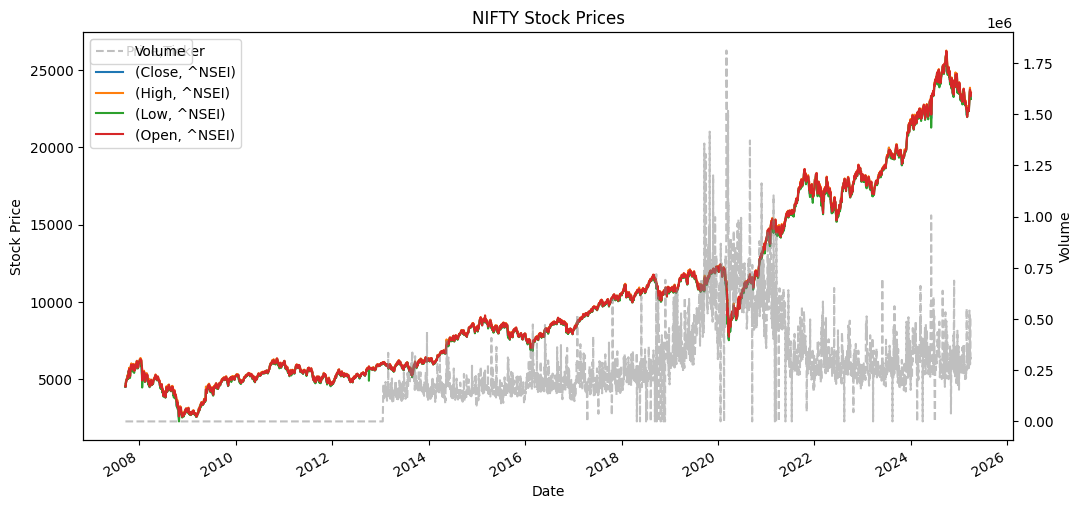

In [63]:
# Example of using the pipeline
df = download_data()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2733 entries, 2014-01-02 to 2025-04-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2733 non-null   float64
 1   High    2733 non-null   float64
 2   Low     2733 non-null   float64
 3   Open    2733 non-null   float64
 4   Volume  2733 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 128.1 KB


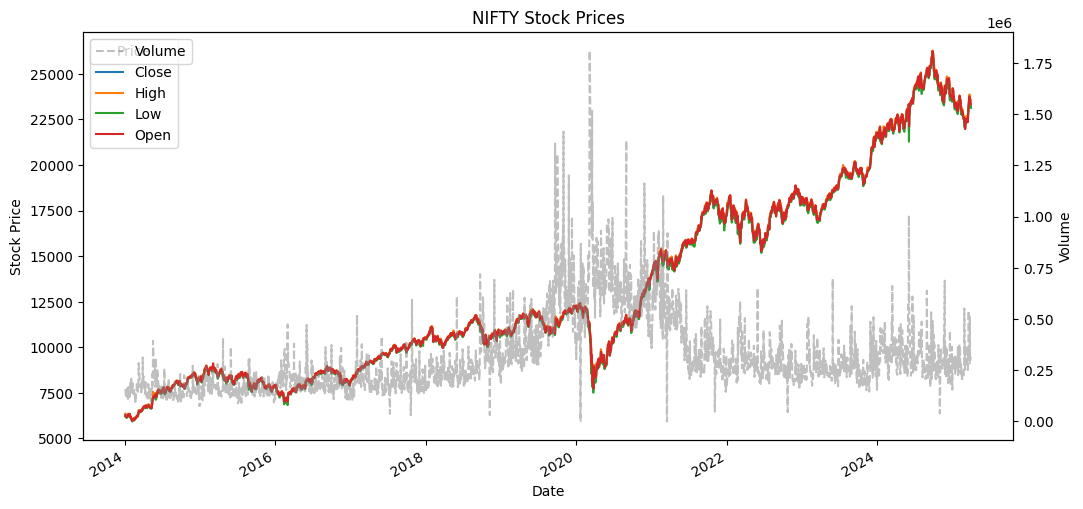

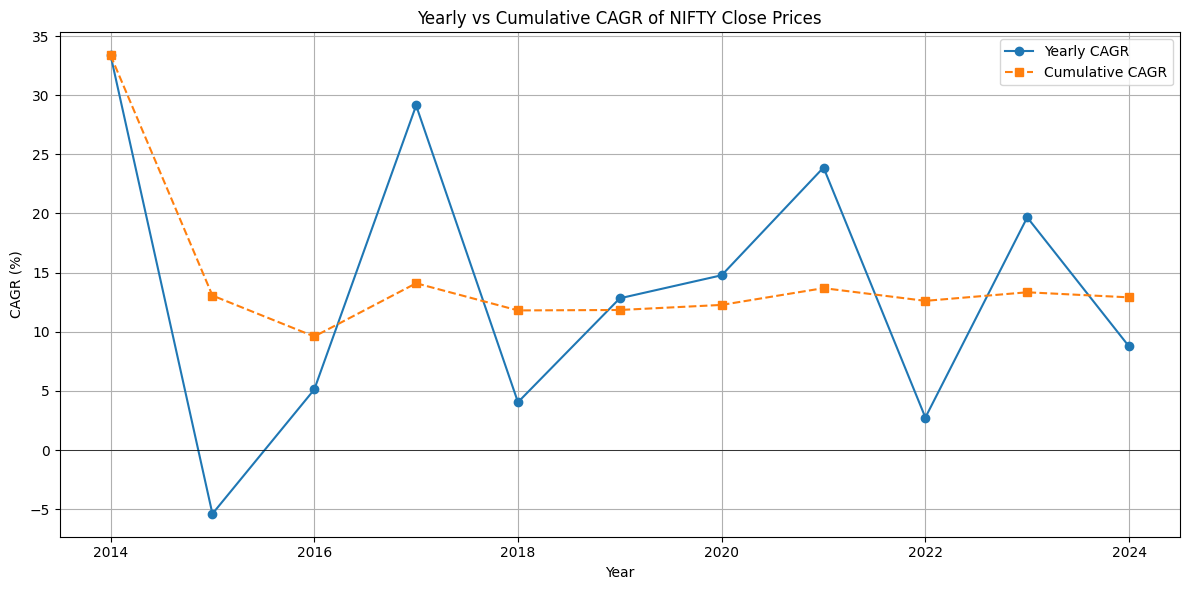

In [64]:
truncated_df = preprocess(df)
normalize_truncated_df = normalize(truncated_df, scale='divide')

In [65]:
npast=5
random=noise_dic(type='gaussian', n = len(normalize_truncated_df))
lagged_df = lag(normalize_truncated_df, random, label='Close', lags=npast)

# Reshape the 1D arrays to 3D arrays to feed in the model
X, y, scaler = scale_data(lagged_df)
X_train, X_test, y_train, y_test, split_idx = train_test_split(X, y,train_ratio=0.7)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((1909, 6, 1), (819, 6, 1))

4. Summary of training at least three variations of the Deep Learning model you selected. For example, you can use different clustering techniques or different hyperparameters.

***Three deeplearning techniques namely simple neutral network, LSTM, Convolution Neural Network were studied to predict stock Close price for NIFTY. Since stock price movements are markovian, the features include the previous day Close price and a gaussian white random noise. ***

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


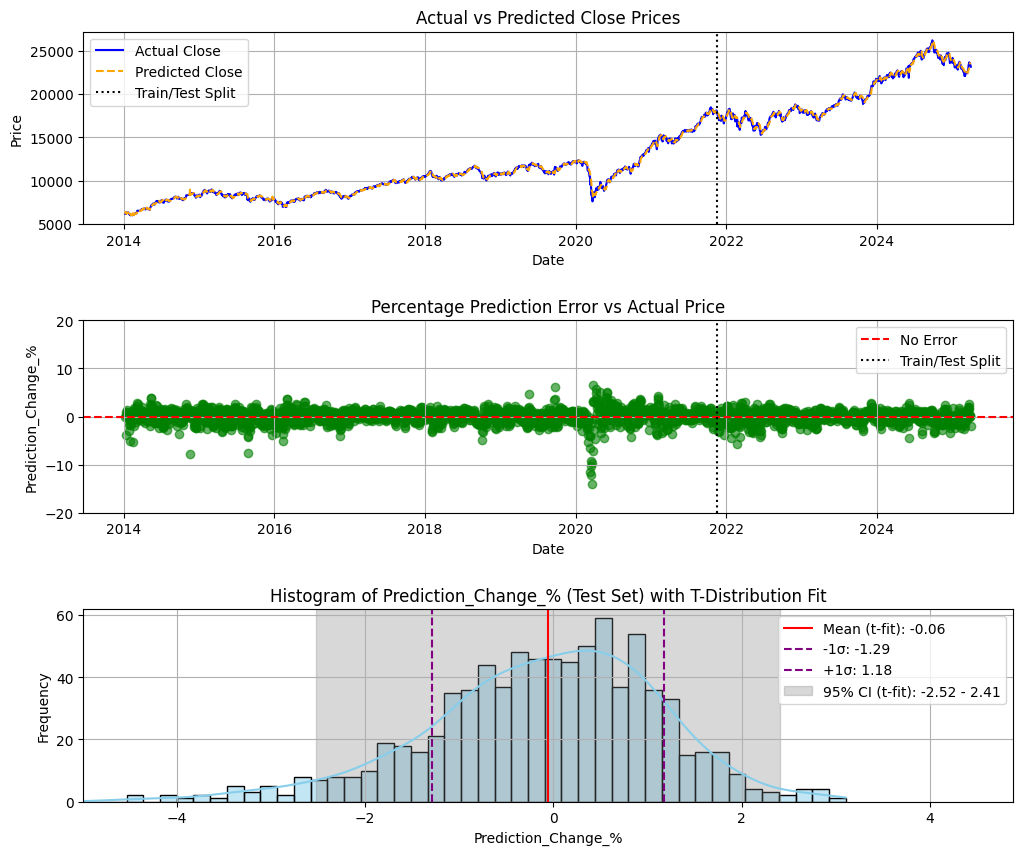

In [66]:
##Simple Neural network
model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)


# Make prediction
y_pred= model.predict(X)
y_pred = y_pred * truncated_df['Close'].iloc[0]
y_initial=truncated_df['Close'].iloc[npast:]

metrics = evaluate_model(y_initial, y_pred)
list_pred = plot_predictions(truncated_df, y_pred, npast, len(y_train))

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 6, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 6, 150)              │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 6, 150)              │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.8690 - val_loss: 0.2644
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0340 - val_loss: 0.2539
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0289 - val_loss: 0.1536
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0248 - val_loss: 0.1386
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0212 - val_loss: 0.0700
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0071 - val_loss: 0.0018
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0

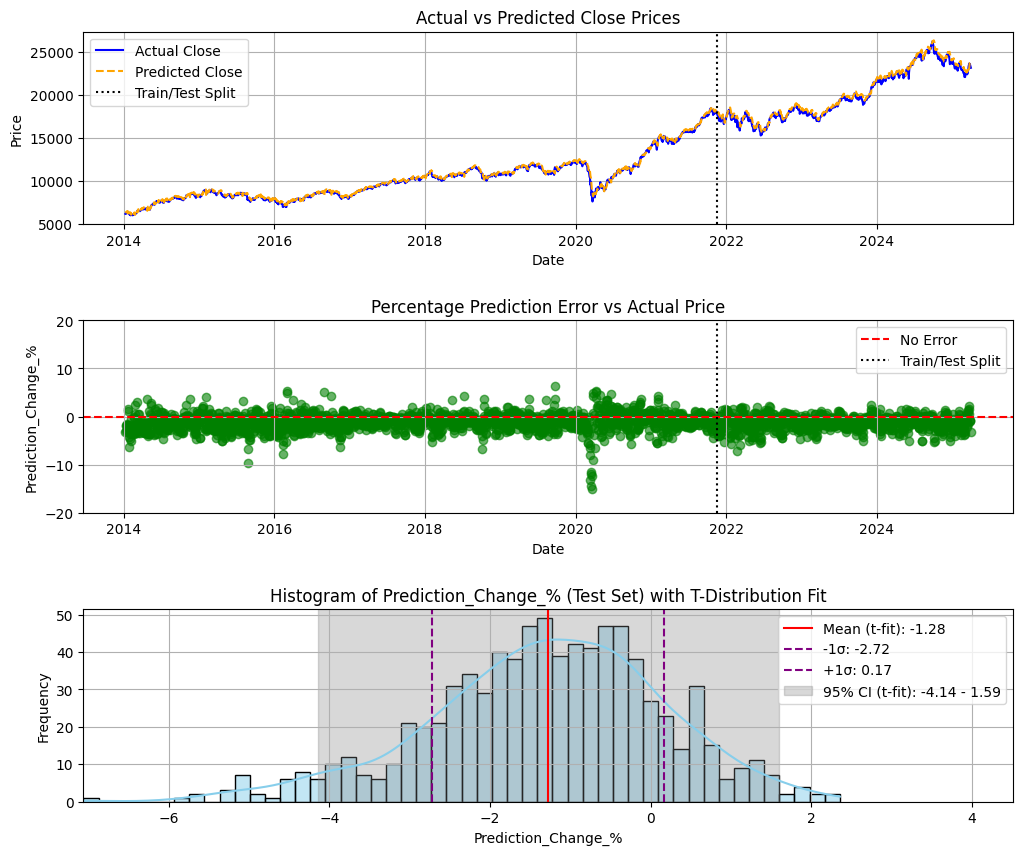

In [67]:
##LSTM

# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

# Training the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)


# Make prediction
y_pred= model.predict(X)
y_pred = y_pred * truncated_df['Close'].iloc[0]
y_initial=truncated_df['Close'].iloc[npast:]

metrics = evaluate_model(y_initial, y_pred)
list_pred = plot_predictions(truncated_df, y_pred, npast, len(y_train))

47/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


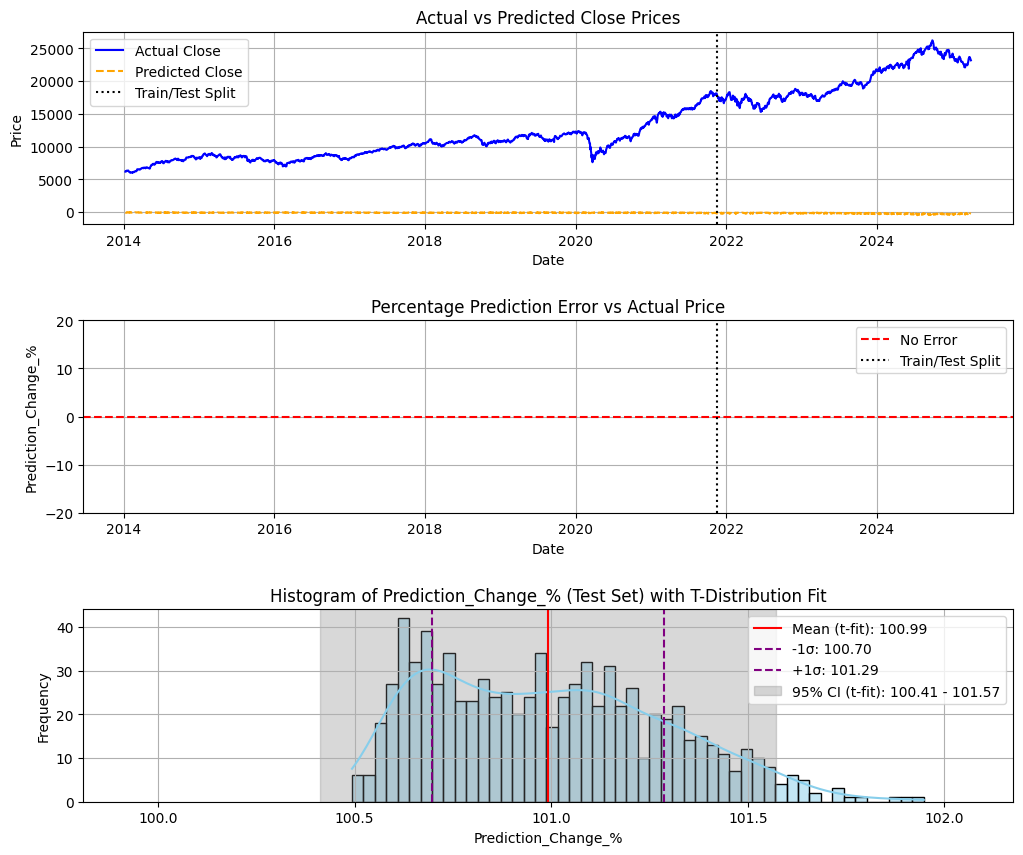

In [69]:
#COnvolution Neural Network
model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Make prediction
y_pred= model.predict(X)
y_pred = y_pred * truncated_df['Close'].iloc[0]
y_initial=truncated_df['Close'].iloc[npast:]

metrics = evaluate_model(y_initial, y_pred)
list_pred = plot_predictions(truncated_df, y_pred, npast, len(y_train))

5. A  paragraph explaining which of your Deep Learning models you recommend as a final model that best fits your needs in terms of accuracy or explainability.

***The three models: simple neutral network, LSTM, Convolution Neural Network.In order to compare the three methods percentage change in predicted values for the test data was plotted as a hitogram. We find Simple neural network works the best followed by LSTM and CNN. The setup for CNN seems to be off and needs parameter tuning.***

6. Summary Key Findings and Insights, which walks your reader through the main findings of your modeling exercise.:

***This deep learning model helps us to predict Close price the next day given prce of data today. It is beneficial to understand how the stock price will change over a day and provided the confidence interval for such predictions.  This will also be helpful to understand the price variation of derivative related to the stock price.***

7. Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model or adding specific data features to achieve a better model.

***Much could be improved in terms of parameterization of more complex deep learning method like CNN. Also, the feauture selection could be improved to include past data and other complex market parameters to make more informed prediction. ***